### Count regression

This notebook demonstrates the use of TFP for regression on count data. The dataset is the number of fish caught in a state park. 

* Poisson Regression
* Zero Infated Poisson Regression

#### Results from the paper

In [2]:
nt = 35040
-67192.75 / nt, -58243/nt, -58164/nt #Poisson, NB, Count Trafo

(-1.9176013127853881, -1.6621860730593607, -1.659931506849315)

In [3]:
import tensorflow as tf
try: #If running in colab 
    import google.colab
    IN_COLAB = True 
except:
    IN_COLAB = False
if (not tf.__version__.startswith('2')): #Checking if tf 2.0 is installed
    if IN_COLAB: #If running in colab install tf 2.0
        !pip install tensorflow==2.0.0-alpha0
        !pip install pip install tfp-nightly==0.7.0-dev20190511
    print('Please install tensorflow 2.0 to run this notebook')
print('Tensorflow version: ',tf.__version__, ' running in colab?: ', IN_COLAB)

Tensorflow version:  2.0.0-alpha0  running in colab?:  False


In [4]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
import seaborn as sns
import tensorflow_probability as tfp

sns.reset_defaults()
#sns.set_style('whitegrid')
sns.set_context(context='talk',font_scale=0.7)


%matplotlib inline
plt.style.use('default')

tfd = tfp.distributions
tfb = tfp.bijectors
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense
print("TFP Version", tfp.__version__)
print("TF  Version",tf.__version__)
np.random.seed(42)
tf.random.set_seed(42)

TFP Version 0.7.0-dev20190511
TF  Version 2.0.0-alpha0


### Creating some count data

This is just to demonstrate how to use TF distributions for a Poisson distribution, with given parameters. Below we learn the paramters. 

2.0
1.4142135


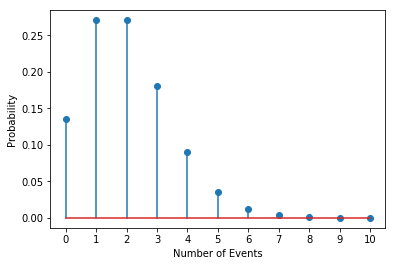

In [5]:
# 10          20       30        40       50         55
#123456789012345678901234567890123456789012345678901234
dist = tfd.poisson.Poisson(rate = 2) #A
vals = np.linspace(0,10,11) #B
p = dist.prob(vals) #C
print(dist.mean().numpy())  #D
print(dist.stddev().numpy())   #E
plt.xticks(vals)
plt.stem(vals, p)
plt.xlabel('Number of Events')
plt.ylabel('Probability')
plt.savefig('ch05_rain.pdf')

#A Poisson distribution with parameter rate 2
#B some values for the x-axis in figure 5.rain
#C the probability for the values
#D the mean value yielding 2.0
#E the standard deviation yielding sqrt(2.0) = 1.41...

## Loading some count data

We use some traditional count data from: https://stats.idre.ucla.edu/r/dae/zip/. The number fish caught during a state park visit.

In [6]:
# Alternative version
# dat = np.loadtxt('https://raw.githubusercontent.com/tensorchiefs/dl_book/master/data/nb_data.csv') 
# X = dat[...,0:3]
# y = dat[...,4]
# X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.33, random_state=42)
# X_tr.shape, y_tr.shape, X_te.shape, y_te.shape

In [7]:
# The Fish Data Set
# See example 2 from https://stats.idre.ucla.edu/r/dae/zip/ 
#"nofish","livebait","camper","persons","child","xb","zg","count"
#dat = np.loadtxt('../data/fish.csv', delimiter=',', skiprows=1)
# dat = np.loadtxt('https://raw.githubusercontent.com/tensorchiefs/dl_book/master/data/fish.csv',delimiter=',', skiprows=1)
# X = dat[...,1:5] #"livebait","camper","persons","child
# y = dat[...,7]
# X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.33, random_state=42)
# d = X_tr.shape[1]
# X_tr.shape, y_tr.shape, X_te.shape, y_te.shape,dat.shape


In [8]:
# The Deer Data Set
dat = np.loadtxt('../../dl_book_playground/deerdata/deer_train.csv',delimiter=',', skiprows=1)
X_tr = dat[:,-1:]
y_tr = dat[:,-1]
X_tr = dat[:,:-1]
y_tr = dat[:,-1]
print(np.sum(y_tr), np.sum(X_tr[:,0]))#265911,#17520


dat = np.loadtxt('../../dl_book_playground/deerdata/deer_test.csv',delimiter=',', skiprows=1)
X_te = dat[:,-1:]
y_te = dat[:,-1]
X_te = dat[:,:-1]
y_te = dat[:,-1]
np.sum(y_te),np.sum(X_te[:,12])#2610,#75744

265911.0 17520.0


(75744.0, 2610.0)

In [9]:
d = X_tr.shape[1]
X_tr.shape, y_tr.shape, X_te.shape, y_te.shape,dat.shape

((140256, 222), (140256,), (35040, 222), (35040,), (35040, 223))

38.0

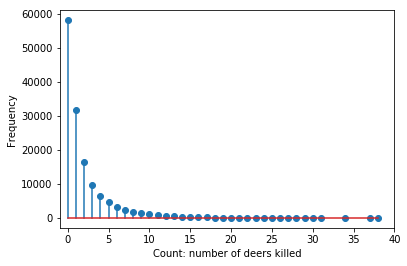

In [138]:
vals, counts = np.unique(y_tr, return_counts=True)
plt.stem(vals, counts)
plt.xlabel('Count: number of deers killed')
plt.ylabel('Frequency')
plt.xlim(-1,40)
plt.savefig('ch05_school.pdf')
np.max(y_tr)

## 1 Doing linear regression

In this section we do a standard linear regression.

In [9]:
model_lr = tf.keras.Sequential() #A
model_lr.add(tf.keras.layers.Dense(1,input_dim=d, activation='linear')) #B 
model_lr.compile(loss='mean_squared_error',optimizer=tf.optimizers.Adam(learning_rate=0.01))

In [10]:
hist_lr = model_lr.fit(x=X_tr, y=y_tr, validation_data=(X_te, y_te), epochs=5, verbose=True);
#hist_lr = model_lr.fit(x=X_tr, y=np.sqrt(y_tr), validation_data=(X_te, y_te), epochs=600, verbose=False);

Train on 140256 samples, validate on 35040 samples
Epoch 1/5
140256/140256 [==============================] - 4s 32us/sample - loss: 6.0291 - val_loss: 7.4762
Epoch 2/5
140256/140256 [==============================] - 5s 34us/sample - loss: 5.8744 - val_loss: 7.4651
Epoch 3/5
140256/140256 [==============================] - 5s 34us/sample - loss: 5.8696 - val_loss: 7.3960
Epoch 4/5
140256/140256 [==============================] - 5s 33us/sample - loss: 5.8641 - val_loss: 7.4229
Epoch 5/5
140256/140256 [==============================] - 5s 32us/sample - loss: 5.8687 - val_loss: 7.4149


5.901177778394696

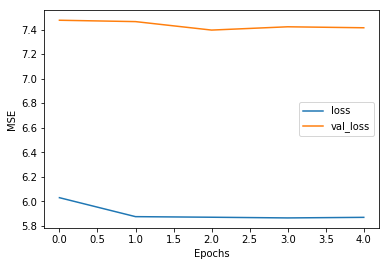

In [11]:
plt.plot(hist_lr.history['loss'])
plt.plot(hist_lr.history['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.ylabel('MSE')
plt.xlabel('Epochs')
np.mean(hist_lr.history['loss'])

In [15]:
X_te.dtype, np.sum(X_te)

(dtype('float64'), 117047.99999999988)

In [16]:
y_hat_te = model_lr.predict(X_te)

In [21]:
y_hat_te = y_hat_te[:,0]

In [23]:
#y_hat_te = model_lr.predict(X_te)
np.sqrt(np.mean((y_hat_te - y_te)**2)),np.mean(np.abs(y_hat_te - y_te)) #(8.540011535073502, 6.001939873018208)
#np.sqrt(np.mean((y_hat_te**2 - y_te)**2)),np.mean(np.abs(y_hat_te**2 - y_te)) #(8.540011535073502, 6.001939873018208)

(2.7230254501034823, 1.682203523947785)

Text(0, 0.5, 'Predicted ')

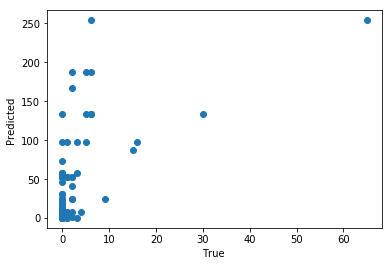

In [11]:
plt.scatter(y_te, y_hat_te**2)
plt.xlabel('True ')
plt.ylabel('Predicted ')

In [30]:
y_hat_tr = model_lr.predict(X_tr) #Testset
sigma_hat_2 = np.var(y_hat_tr.flatten() - y_tr) 
0.5*np.log(2 * np.pi * sigma_hat_2) + 0.5*np.mean((y_hat_te - y_te)**2)/sigma_hat_2

2.436387828257325

## 2 Doing Poisson Regression

#### Definition of the Model

$$
    Y \thicksim \tt{Pois}(exp(w^{T} \cdot x + b))
$$

In [17]:
# 10          20       30        40       50         55
#123456789012345678901234567890123456789012345678901234
inputs = tf.keras.layers.Input(shape=(X_tr.shape[1],))  
# h = tf.keras.layers.Dense(500, 
#          activation='relu')(inputs)
# h = tf.keras.layers.Dropout(0.1)(h)
# h = tf.keras.layers.Dense(100, 
#          activation='relu')(inputs)
# h = tf.keras.layers.Dropout(0.3)(h)
# h = tf.keras.layers.Dense(10, 
#          activation='relu')(inputs)
rate = tf.keras.layers.Dense(1, 
         activation=tf.exp, #A
         bias_initializer='zeros', 
         kernel_initializer='zeros')(inputs)

p_y = tfp.layers.DistributionLambda(tfd.Poisson)(rate) #B 

model_p = Model(inputs=inputs, outputs=p_y) #C


def negloglik(y_true, y_hat): #D
  return -y_hat.log_prob(y_true)

model_p.compile(tf.optimizers.Adam(learning_rate=0.001), 
                loss=negloglik)

#A Definition of a single layer with one output
#B We use exponential of the output to model the rate
#C Glueing input and output together. Note that output is a tf.distribution
#D Since the second argument is the output of the model it is a distribution. It's as simple as calling log_prob to calculate the NLL.

model_p.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 222)]             0         
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 223       
_________________________________________________________________
distribution_lambda_3 (Distr ((None, 1), (None, 1))    0         
Total params: 223
Trainable params: 223
Non-trainable params: 0
_________________________________________________________________


In [18]:
hist_p = model_p.fit(x=X_tr, y=y_tr, validation_data=(X_te, y_te), epochs=50, verbose=True);

Train on 140256 samples, validate on 35040 samples
Epoch 1/50
140256/140256 [==============================] - 6s 43us/sample - loss: 1.9508 - val_loss: 1.9902
Epoch 2/50
140256/140256 [==============================] - 5s 38us/sample - loss: 1.8143 - val_loss: 1.9498
Epoch 3/50
140256/140256 [==============================] - 6s 39us/sample - loss: 1.7941 - val_loss: 1.9346
Epoch 4/50
140256/140256 [==============================] - 5s 38us/sample - loss: 1.7866 - val_loss: 1.9302
Epoch 5/50
140256/140256 [==============================] - 5s 38us/sample - loss: 1.7828 - val_loss: 1.9279
Epoch 6/50
140256/140256 [==============================] - 5s 39us/sample - loss: 1.7808 - val_loss: 1.9242
Epoch 7/50
140256/140256 [==============================] - 6s 39us/sample - loss: 1.7799 - val_loss: 1.9245
Epoch 8/50
140256/140256 [==============================] - 5s 39us/sample - loss: 1.7790 - val_loss: 1.9282
Epoch 9/50
140256/140256 [==============================] - 5s 39us/sample - 

1.9223715233775578

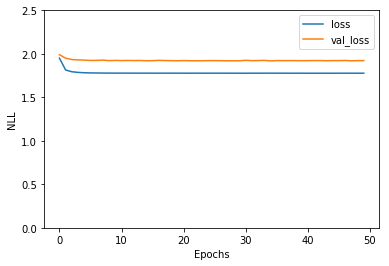

In [19]:
plt.plot(hist_p.history['loss'])
plt.plot(hist_p.history['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.xlabel('Epochs')
plt.ylabel('NLL')
np.mean(hist_p.history['loss'])
plt.ylim(0,2.5)
np.mean(hist_p.history['val_loss'][-20:]) #Paper -1.91760131278

In [15]:
model_pm = tf.keras.models.Model(inputs=inputs, outputs=p_y.mean()) 
y_hat_te = model_pm(X_te)
np.sqrt(np.mean((y_hat_te - y_te)**2)),np.mean(np.abs(y_hat_te - y_te))

(9.662406, 4.595026)

In [43]:
# First build the model matrix, appending an intercept term
d = np.shape(X_tr)[1]
Xm = np.ones((np.shape(X_tr)[0],d+1))
Xm[:,1:d+1] = X_tr

array([[1.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        1.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        1.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.000000

In [47]:
d = np.shape(X_te)[1]
X_te_in = np.ones((np.shape(X_te)[0],d+1))
X_te_in[:,1:d+1] = X_te

In [49]:
fit = tfp.glm.fit(
    model_matrix=Xm,
    response=y_tr,
    model=tfp.glm.Poisson()
)

$$
\lambda = exp(X \cdot \hat \beta)
$$

In [84]:
d = np.matmul(X_te_in,fit[0])
lam = np.exp(d)

In [85]:
dd = tfd.Poisson(lam).log_prob(y_te).numpy()

In [91]:
np.mean(dd) - -1.917601 #-1.917601 according to R

2.0509087961251282e-07

Training Set 2.3400428 59
Validation Set 5.050113 36


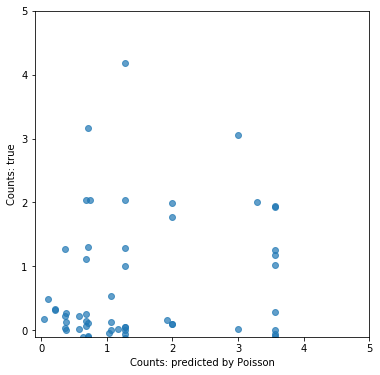

In [16]:
plt.figure(figsize=(6,6))
plt.xlim(-0.1,5)
plt.ylim(-0.1,5)
y_hat_tr = model_pm(X_tr)
plt.scatter(y_hat_te, np.random.normal(loc=y_te,scale=0.2), alpha=0.7)
plt.xlabel('Counts: predicted by Poisson')
plt.ylabel('Counts: true')
plt.savefig('ch05_pois.pdf')
print('Training Set', np.mean(np.square(y_hat_tr[y_tr == 0])),np.sum(y_hat_tr[y_tr == 0]>0.5))
print('Validation Set', np.mean(np.square(y_hat_te[y_te == 0])),np.sum(y_hat_te[y_te == 0]>0.5))

## 3 Using zero inflated Poisson Regression

We define a network with two outputs. One for the poisson mean, one for the prob that there is a zero. 

First, we define a function which produces the zero inflated poisson distribution. 

### Definition of the distribution

In [10]:
# 10          20       30        40       50         55
#123456789012345678901234567890123456789012345678901234
# Listing 5.l_zi
def zero_inf(out): 
    rate = tf.math.exp(out[:,0]) #A 
    #rate = tf.math.softplus(out[:,0]) #A 
    s = tf.math.sigmoid(out[:,1:]) #B  
    probs = tf.concat([s, 1-s], axis=1) #C 
    print(np.min(rate), " ", np.max(rate), " ", np.min(s), np.max(s),"  ",np.min(out[:,1:]), np.max(out[:,1:]))
    return tfd.Mixture(
          cat=tfd.Categorical(probs=probs),#D
          components=[
            tfd.Deterministic(loc=tf.zeros_like(rate)), #E
            tfd.Poisson(rate=rate), #F 
        ])

#A The first component codes for the rate. We use exponential to guaranty values >0.
#B The second component codes for the zero inflation, using sigmoid squeezes the value between 0 and 1.
#C The two probabilities for zeros or Poissonian  
#D The tfd.Categorical allows to create a mixture of two components. 
#E Zero as a deterministic value 
#F Value drawn from a Poissonian

In [11]:
## testinging the distribution
t = np.ones((5,2), dtype=np.float32)
t[4,0]=0.999
t[4,1]=10
zero_inf(t).mean()

W0705 09:07:26.471500 139916574320384 deprecation.py:323] From /usr/local/lib/python3.5/dist-packages/tensorflow_probability/python/distributions/mixture.py:154: Categorical.event_size (from tensorflow_probability.python.distributions.categorical) is deprecated and will be removed after 2019-05-19.
Instructions for updating:
The `event_size` property is deprecated.  Use `num_categories` instead.  They have the same value, but `event_size` is misnamed.


2.715565   2.7182817   0.7310586 0.9999546    1.0 10.0


<tf.Tensor: id=52, shape=(5,), dtype=float32, numpy=
array([7.3105848e-01, 7.3105848e-01, 7.3105848e-01, 7.3105848e-01,
       1.2333754e-04], dtype=float32)>

### Definition of the model

In [13]:
## Definition of the model
# 10          20       30        40       50         55
#123456789012345678901234567890123456789012345678901234
## Definition of the custom parametrized distribution
from tensorflow.keras.regularizers import l2
inputs = tf.keras.layers.Input(shape=(X_tr.shape[1],))  
h = tf.keras.layers.Dense(500, activation='relu')(inputs)
h = tf.keras.layers.Dropout(0.1)(h)
h = tf.keras.layers.Dense(100, activation='relu')(h)
h = tf.keras.layers.Dropout(0.3)(h)
h = tf.keras.layers.Dense(10, activation='relu')(h)


out = Dense(2,  #A
            kernel_regularizer=l2(0.01), #B
            bias_regularizer=l2(0.01))(h)#B

p_y_zi = tfp.layers.DistributionLambda(zero_inf)(out)
model_zi = Model(inputs=inputs, outputs=p_y_zi)

#A A dense layer is used without activation. The transformation is done in zero_inf listing 5.l_zi 
#B Using a regularisation prevents the network from learning too large weights. Without regularisation, you run into numerical problems.
model_zi.summary()

Tensor("distribution_lambda_1/Exp:0", shape=(None,), dtype=float32)   Tensor("distribution_lambda_1/Exp:0", shape=(None,), dtype=float32)   Tensor("distribution_lambda_1/Sigmoid:0", shape=(None, 1), dtype=float32) Tensor("distribution_lambda_1/Sigmoid:0", shape=(None, 1), dtype=float32)    Tensor("distribution_lambda_1/strided_slice_2:0", shape=(None, 1), dtype=float32) Tensor("distribution_lambda_1/strided_slice_3:0", shape=(None, 1), dtype=float32)
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 222)]             0         
_________________________________________________________________
dense_4 (Dense)              (None, 500)               111500    
_________________________________________________________________
dropout_2 (Dropout)          (None, 500)               0         
_________________________________________________________________


### Training of the model (by hand) [optional]

The following code trains the NN using a evaluation loop by hand. This help us to find instabilities, which we got rid off using regularisation. See also: https://www.tensorflow.org/beta/guide/keras/training_and_evaluation#part_ii_writing_your_own_training_evaluation_loops_from_scratch


In [ ]:
optimizer=tf.optimizers.RMSprop(learning_rate=0.05)
loss_values = np.zeros((1000))
for e in range(10):
    with tf.GradientTape() as tape:
        y_hat = model_zi(X_tr)
        loss_value = -tf.reduce_mean(y_hat.log_prob(y_tr))
        loss_values[e] = loss_value
        grads = tape.gradient(loss_value, model_zi.trainable_weights)
        weights =  model_zi.trainable_weights       
        optimizer.apply_gradients(zip(grads,weights))

0.75575185   1.4359596   0.3998792 0.5813893    -0.40596858 0.32847917


### Training using keras' build in training

In [14]:
def negloglik2(y_true, y_hat):
    # return -tf.reduce_mean(y_hat.log_prob(y_true))
    return -tf.reduce_mean(y_hat.log_prob(tf.reshape(y_true,(-1,))))

model_zi.compile(optimizer=tf.optimizers.Adam(learning_rate=0.001), loss=negloglik2)
hist_zi = model_zi.fit(x=X_tr, y=y_tr, validation_data=(X_te, y_te), epochs=30, verbose=True)#, callbacks=[tb]);

Train on 140256 samples, validate on 35040 samples
Epoch 1/30
140256/140256 [==============================] - 17s 120us/sample - loss: 1.7653 - val_loss: 1.8607
Epoch 2/30
140256/140256 [==============================] - 16s 115us/sample - loss: 1.7100 - val_loss: 1.8313
Epoch 3/30
140256/140256 [==============================] - 16s 117us/sample - loss: 1.6993 - val_loss: 1.8201
Epoch 4/30
140256/140256 [==============================] - 16s 116us/sample - loss: 1.6893 - val_loss: 1.8508
Epoch 5/30
140256/140256 [==============================] - 16s 114us/sample - loss: 1.6824 - val_loss: 1.8299
Epoch 6/30
140256/140256 [==============================] - 16s 113us/sample - loss: 1.6753 - val_loss: 1.8304
Epoch 7/30
140256/140256 [==============================] - 17s 121us/sample - loss: 1.6716 - val_loss: 1.8305
Epoch 8/30
140256/140256 [==============================] - 17s 122us/sample - loss: 1.6683 - val_loss: 1.8421
Epoch 9/30
140256/140256 [==============================] - 1

(1.8200529714697573, 1.8335629808926068)

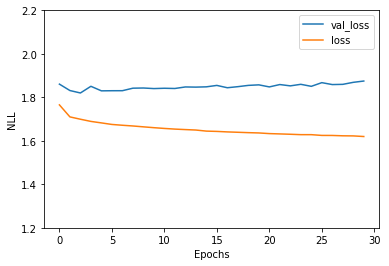

In [22]:
#plt.plot(hist_p.history['loss'],linestyle='-.')
plt.plot(hist_zi.history['val_loss'])
#plt.plot(hist_zi.history['loss'])
plt.plot(hist_zi.history['loss'])
plt.ylim(1.2,2.2)
#plt.legend(['Poisson loss','Poisson val_loss','ZI loss','ZI val_loss'])
plt.legend(['val_loss','loss'])
plt.xlabel('Epochs')
plt.ylabel('NLL')
plt.savefig('ch05_flik.pdf')
#np.mean(hist_p.history['val_loss'][-30:]) ,
np.min(hist_zi.history['val_loss']) ,np.mean(hist_zi.history['val_loss'][1:8]) 

In [23]:
model_zi = tf.keras.models.Model(inputs=inputs, outputs=p_y_zi.mean())
y_hat_te = model_zi(X_te)
#mean_absolute_error(y_hat_te, y_te), mean_squared_error(y_hat_te, y_te)
np.sqrt(np.mean((y_hat_te - y_te)**2)),np.mean(np.abs(y_hat_te - y_te))

(6.5221105, 3.2028117)

Training Set 2.658582 61
Validation Set 5.71879 38


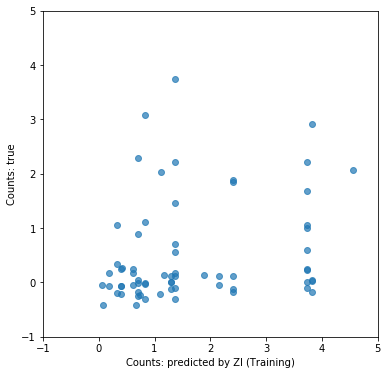

In [24]:
plt.figure(figsize=(6,6))
plt.xlim(-1,5)
plt.ylim(-1,5)
y_hat_tr = model_zi(X_tr)

plt.scatter(y_hat_te, np.random.normal(loc=y_te,scale=0.2), alpha=0.7)
plt.xlabel('Counts: predicted by ZI (Training)')
plt.ylabel('Counts: true')

plt.savefig('ch05_zi.pdf')
print('Training Set', np.mean(np.square(y_hat_tr[y_tr == 0])),np.sum(y_hat_tr[y_tr == 0]>0.5))
print('Validation Set', np.mean(np.square(y_hat_te[y_te == 0])),np.sum(y_hat_te[y_te == 0]>0.5))

In [142]:
# 10          20       30        40       50         55
#123456789012345678901234567890123456789012345678901234
#See https://www.tensorflow.org/probability/api_docs/python/tfp/distributions/QuantizedDistribution

def mixture(out, num=3,debug=False): 
    loc, un_scale, logits = tf.split(out,
                                     num_or_size_splits=num,
                                     axis=-1)
    scale = tf.nn.softplus(un_scale)
    if (debug):
        print('location', loc.numpy(),' scale ',scale.numpy(), 'logits ', logits.numpy(), ' ', tf.nn.softmax(logits).numpy())
#     discretized_logistic_dist=tfd.TransformedDistribution(
#         distribution=tfd.Logistic(loc=loc, scale=scale),
#         bijector=tfb.AffineScalar(shift=-0.5))
    
    #print("mix_logi ", np.min(logits), " ", np.max(logits), " ", np.min(scale), np.max(scale),"  ",np.min(loc), np.max(loc))
    mixture_dist = tfd.MixtureSameFamily(
        mixture_distribution=tfd.Categorical(probs=tf.nn.softmax(logits)), #logits will be normalized to one
        components_distribution=tfd.Poisson(rate=scale))
        components_distribution=tfd.Logistic(loc=loc, scale=scale))
    
    
    return mixture_dist

In [169]:
# 10          20       30        40       50         55
#123456789012345678901234567890123456789012345678901234
#See https://www.tensorflow.org/probability/api_docs/python/tfp/distributions/QuantizedDistribution
def mixture_discrete(out, bits=6, num=3): 
    loc, un_scale, logits = tf.split(out,
                                     num_or_size_splits=num,
                                     axis=-1)
    scale = 0.5 + tf.nn.softplus(un_scale)
    discretized_logistic_dist = tfd.QuantizedDistribution(
    distribution=tfd.TransformedDistribution(
        #distribution=tfd.Poisson(rate=scale),
        distribution=tfd.Logistic(loc=loc, scale=scale),
        bijector=tfb.AffineScalar(shift=-0.5)),
    low=0.,
    #high=2**16 - 1.)
    high=2**bits - 1.)
    mixture_dist = tfd.MixtureSameFamily(
        mixture_distribution=tfd.Categorical(logits=logits), #logits will be normalized to one
        components_distribution=discretized_logistic_dist)
    return mixture_dist

In [182]:
from tensorflow.keras.regularizers import l2
inputs = tf.keras.layers.Input(shape=(X_tr.shape[1],))  
h = tf.keras.layers.Dense(500, activation='relu')(inputs)
h = tf.keras.layers.Dropout(0.1)(h)
h = tf.keras.layers.Dense(100, activation='relu')(h)
h = tf.keras.layers.Dropout(0.3)(h)
h = tf.keras.layers.Dense(6, activation='relu')(h)
#tt = tf.concat([loc1, scales1, logits], axis=1)
p_y = tfp.layers.DistributionLambda(mixture_discrete)(h) 
model = tf.keras.models.Model(inputs=inputs, outputs=p_y)
#model_mean = tf.keras.models.Model(inputs=inputs, outputs=p_y.mean()) #For evaluation we need the mean
model.compile(optimizer=tf.optimizers.Adam(0.001), loss=negloglik2)
model.summary()

Model: "model_31"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_17 (InputLayer)        [(None, 222)]             0         
_________________________________________________________________
dense_56 (Dense)             (None, 500)               111500    
_________________________________________________________________
dropout_32 (Dropout)         (None, 500)               0         
_________________________________________________________________
dense_57 (Dense)             (None, 100)               50100     
_________________________________________________________________
dropout_33 (Dropout)         (None, 100)               0         
_________________________________________________________________
dense_58 (Dense)             (None, 6)                 606       
_________________________________________________________________
distribution_lambda_17 (Dist ((None,), (None,))        0  

In [183]:
hist = model.fit(X_tr, y_tr, epochs=15, verbose=1, validation_data=(X_te, y_te))

Train on 140256 samples, validate on 35040 samples
Epoch 1/15
140256/140256 [==============================] - 16s 112us/sample - loss: 1.6407 - val_loss: 1.7031
Epoch 2/15
140256/140256 [==============================] - 15s 108us/sample - loss: 1.6237 - val_loss: 1.6984
Epoch 3/15
140256/140256 [==============================] - 15s 110us/sample - loss: 1.6178 - val_loss: 1.6994
Epoch 4/15
140256/140256 [==============================] - 16s 112us/sample - loss: 1.6135 - val_loss: 1.7010
Epoch 5/15
140256/140256 [==============================] - 15s 109us/sample - loss: 1.6103 - val_loss: 1.6999
Epoch 6/15
140256/140256 [==============================] - 15s 109us/sample - loss: 1.6082 - val_loss: 1.6986
Epoch 7/15
140256/140256 [==============================] - 16s 111us/sample - loss: 1.6050 - val_loss: 1.7071
Epoch 8/15
140256/140256 [==============================] - 15s 108us/sample - loss: 1.6033 - val_loss: 1.7030
Epoch 9/15
140256/140256 [==============================] - 1

1.6596534722871066

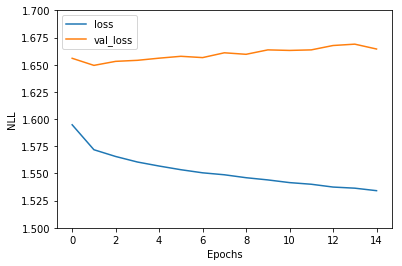

In [172]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.xlabel('Epochs')
plt.ylabel('NLL')
np.mean(hist.history['loss'])
plt.ylim(1.5,1.7)
np.mean(hist.history['val_loss'][-20:]) #Paper -1.91760131278

In [173]:
model_tt = tf.keras.models.Model(inputs=inputs, outputs=h)

In [174]:
idx = np.random.permutation(len(y_te))[1:10]

In [175]:
idx

array([19071, 10341,  1886, 34908, 14226, 15724,  6523,  8489, 31671])

In [176]:
ttt = model_tt.predict(X_te[idx])

In [177]:
ttt[:,0:3] #locs

array([[14.084252  ,  0.95350003,  1.6812018 ],
       [ 0.9605331 ,  1.0458815 ,  0.9831837 ],
       [ 4.4329543 ,  1.1802963 ,  1.3234575 ],
       [ 0.        ,  1.0306635 ,  1.151938  ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 9.988787  ,  2.6767857 ,  3.7489762 ],
       [15.006411  ,  2.201109  ,  4.494405  ],
       [ 6.901525  ,  2.2869334 ,  2.9005778 ]], dtype=float32)

In [178]:
tf.nn.softplus(ttt[:,3:6]) #scales

<tf.Tensor: id=5371819, shape=(9, 3), dtype=float32, numpy=
array([[ 1.0458436 ,  2.5068715 , 15.436159  ],
       [ 1.2940074 ,  1.0343745 ,  0.8167605 ],
       [ 1.3377087 ,  1.3352058 ,  5.7360687 ],
       [ 1.696017  ,  1.5103444 ,  0.70041347],
       [ 0.6931472 ,  0.6931472 ,  0.6931472 ],
       [ 0.6931472 ,  0.6931472 ,  0.6931472 ],
       [ 3.1870227 ,  5.365259  , 15.348511  ],
       [ 2.19981   ,  5.7864537 , 18.979471  ],
       [ 2.968444  ,  3.7179193 ,  9.963851  ]], dtype=float32)>

In [179]:
tf.nn.softmax(ttt[:,6:10]) #Ratios

<tf.Tensor: id=5371822, shape=(9, 4), dtype=float32, numpy=
array([[1.3347227e-03, 1.0969617e-03, 9.9083662e-01, 6.7316825e-03],
       [3.2063237e-01, 3.4335688e-01, 1.8860191e-01, 1.4740887e-01],
       [3.2992776e-02, 3.0145483e-02, 8.9524424e-01, 4.1617490e-02],
       [4.2081079e-01, 2.9309013e-01, 2.0507786e-01, 8.1021301e-02],
       [2.5000000e-01, 2.5000000e-01, 2.5000000e-01, 2.5000000e-01],
       [2.5000000e-01, 2.5000000e-01, 2.5000000e-01, 2.5000000e-01],
       [2.7351452e-03, 3.7166146e-03, 9.9284124e-01, 7.0698647e-04],
       [1.1007785e-03, 2.1666465e-03, 9.9262708e-01, 4.1055288e-03],
       [2.0443810e-02, 2.6732074e-02, 9.5162064e-01, 1.2035624e-03]],
      dtype=float32)>

In [180]:
model2 = tf.keras.models.Model(inputs=inputs, outputs=p_y)

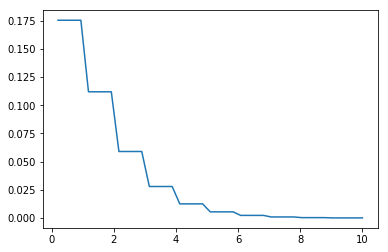

In [181]:
y_vals = np.linspace(-2,10)
py_vals = model2(X_te[23123:23124]).prob(y_vals)
plt.plot(y_vals, py_vals)